In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

set_style("whitegrid")

In [2]:
epee = pd.read_csv('./data/epee.csv').dropna()
saber = pd.read_csv('./data/saber.csv').dropna()
foil = pd.read_csv('./data/foil.csv').dropna()

In [3]:
"""
Function one hot encodes the x variables we will be using (strip location and where initiated)
"""
def ohe_weapon(weapon,names):
    for i in names:
        one_hot = pd.get_dummies(weapon[i])
        weapon = weapon.join(one_hot)
    #one_hot = pd.get_dummies(weapon['initiated'])
    #df = df.join(one_hot)
    return weapon

def ohe_weapon_old(weapon,names):
    one_hot = pd.get_dummies(weapon['strip_location'])
    df = weapon.join(one_hot)
    one_hot = pd.get_dummies(weapon['initiated'])
    df = df.join(one_hot)
    return df
"""
Creates a new column of left_side and right_side, which state if the touch occurs on the left or right side 
(combines the fotl_half and fotl_warning_box) for example
"""
def left_side_right_side(weapon):
    weapon['left_side'] = weapon.apply((lambda x: x['fotl_half'] or x['fotl_warning_box']),axis = 1)
    weapon['right_side'] = weapon.apply((lambda x: x['fotr_half'] or x['fotr_warning_box']),axis = 1)
    return weapon
"""
Same as above but also includes the middle for both sides, so as not to leave it out if wanted
"""
def left_side_right_side_including_middle(weapon):
    weapon['left_side'] = weapon.apply((lambda x: x['fotl_half'] or x['fotl_warning_box'] or x['middle']),axis = 1)
    weapon['right_side'] = weapon.apply((lambda x: x['fotr_half'] or x['fotr_warning_box'] or x['middle']),axis = 1)
    return weapon

"""
Creates the training test split of our data
"""
def tts_weapon(weapon,X_names,y_names):
    return train_test_split(weapon[X_names],weapon[y_names],test_size=.2)

"""
Encodes a new column touch_num which assigns the value of 0 to touch left, 1 to touch right, and 2 for a double
"""
def touch_into_numbers(weapon):
    weapon['touch_num'] = weapon.apply((lambda x: 0 if x['touch'] == 'left' else 1 if x['touch'] == 'right' else 2 if x['touch'] == 'double' else 2),axis=1)
    return weapon

"""
Creates the logistic regression model
"""
def make_weapon_model(train_x,train_y):
    model = LogisticRegression()
    x = train_x
    y = train_y.to_numpy()
    model.fit(x,y)
    return model

"""
Turns the 0-1 array back into their names
"""
def map_names_back(arr):
    ans = []
    if arr[0]:
        ans.append("fotl")
    else:
        ans.append("fotr")
    if arr[2]:
        ans.append("on left")
    else:
        ans.append('on right')
    return ", ".join(ans)

"""
Input: trained model
Creates an array where the x value is what happened, and the y value is the % chance the model gives fotl of scoring the touch
"""
def make_arr_of_touch(model):
    pred = []
    vals = []
    for i in range(16):
        val = [(i >> 3) & 1, (i >> 2) & 1, (i >> 1) & 1,i & 1]
        if (val[0] ^ val[1]) == 0 or (val[2] ^ val[3]) == 0:
            continue
        vals.append(val)

    preds = model.predict_proba(vals)
    pred = list(zip(vals,preds))
        
    preds_sorted = sorted(pred, key = (lambda x:-x[1][0]))
    preds_sorted_named = [(map_names_back(x[0]),x[1][0])  for x in preds_sorted] #stores the probability that fotl scores
    return preds_sorted_named

In [4]:
#one hot encoding the required columns
epee = ohe_weapon_old(epee,['strip_location','initiated'])
foil = ohe_weapon(foil,['strip_location','initiated'])
saber = ohe_weapon(saber,['strip_location','initiated'])
epee

,Unnamed: 0.1,Unnamed: 0,stats_id,weapon_x,initiated,strip_location,body_location,created_date,gfycat_gfy_id,tournament_id,...,touch,download_url,fotl_half,fotl_warning_box,fotr_half,fotr_warning_box,middle,fotl,fotr,neither
0,0,0,DimwittedThisCoypu,epee,fotl,fotr_half,front_arm,1591130715,DimwittedThisCoypu,budapestwch2019,...,right,https://clips.fencingdatabase.com/budapestwch2...,False,False,True,False,False,True,False,False
1,1,4,EcstaticSilverHammerheadshark,epee,fotl,fotr_half,front_arm,1592342612,EcstaticSilverHammerheadshark,budapestwch2019,...,right,https://clips.fencingdatabase.com/budapestwch2...,False,False,True,False,False,True,False,False
3,5,8,ReasonableNippyAoudad,epee,fotr,middle,front_arm,1592405661,ReasonableNippyAoudad,wuxi2018,...,left,https://clips.fencingdatabase.com/wuxi2018/Rea...,False,False,False,False,True,False,True,False
6,8,11,SnoopyUncommonAnophelesmosquito,epee,fotr,fotr_warning_box,foot,1592453746,SnoopyUncommonAnophelesmosquito,bern2018,...,right,https://clips.fencingdatabase.com/bern2018/Sno...,False,False,False,True,False,False,True,False
8,10,13,IllShockedBasenji,epee,fotl,middle,front_arm,1592454343,IllShockedBasenji,bern2018,...,left,https://clips.fencingdatabase.com/bern2018/Ill...,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,4948,83,RigidEveryAnnashummingbird,epee,fotl,middle,torso,1709229318,RigidEveryAnnashummingbird,berne2019,...,left,https://clips.fencingdatabase.com/berne2019/Ri...,False,False,False,False,True,True,False,False
694,4951,87,SilkyLikableAmericankestrel,epee,fotl,middle,torso,1709931616,SilkyLikableAmericankestrel,berne2017,...,right,https://clips.fencingdatabase.com/berne2017/Si...,False,False,False,False,True,True,False,False
695,4952,88,AdeptUniqueCalf,epee,fotr,fotl_warning_box,torso,1709931729,AdeptUniqueCalf,budapestwch2019,...,right,https://clips.fencingdatabase.com/budapestwch2...,False,True,False,False,False,False,True,False
698,4959,97,innocentSarplaninacPhytosaurs,epee,fotl,middle,torso,1711197681,innocentSarplaninacPhytosaurs,champsepee2023,...,left,https://clips.fencingdatabase.com/champsepee20...,False,False,False,False,True,True,False,False


In [5]:
#adding the left_side right_side distinction

epee = left_side_right_side_including_middle(epee)
foil = left_side_right_side(foil)
saber = left_side_right_side(saber)

In [6]:
#adding the left_side right_side distinction

epee = touch_into_numbers(epee)
foil = touch_into_numbers(foil)
saber = touch_into_numbers(saber)
epee

,Unnamed: 0.1,Unnamed: 0,stats_id,weapon_x,initiated,strip_location,body_location,created_date,gfycat_gfy_id,tournament_id,...,fotl_warning_box,fotr_half,fotr_warning_box,middle,fotl,fotr,neither,left_side,right_side,touch_num
0,0,0,DimwittedThisCoypu,epee,fotl,fotr_half,front_arm,1591130715,DimwittedThisCoypu,budapestwch2019,...,False,True,False,False,True,False,False,False,True,1
1,1,4,EcstaticSilverHammerheadshark,epee,fotl,fotr_half,front_arm,1592342612,EcstaticSilverHammerheadshark,budapestwch2019,...,False,True,False,False,True,False,False,False,True,1
3,5,8,ReasonableNippyAoudad,epee,fotr,middle,front_arm,1592405661,ReasonableNippyAoudad,wuxi2018,...,False,False,False,True,False,True,False,True,True,0
6,8,11,SnoopyUncommonAnophelesmosquito,epee,fotr,fotr_warning_box,foot,1592453746,SnoopyUncommonAnophelesmosquito,bern2018,...,False,False,True,False,False,True,False,False,True,1
8,10,13,IllShockedBasenji,epee,fotl,middle,front_arm,1592454343,IllShockedBasenji,bern2018,...,False,False,False,True,True,False,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,4948,83,RigidEveryAnnashummingbird,epee,fotl,middle,torso,1709229318,RigidEveryAnnashummingbird,berne2019,...,False,False,False,True,True,False,False,True,True,0
694,4951,87,SilkyLikableAmericankestrel,epee,fotl,middle,torso,1709931616,SilkyLikableAmericankestrel,berne2017,...,False,False,False,True,True,False,False,True,True,1
695,4952,88,AdeptUniqueCalf,epee,fotr,fotl_warning_box,torso,1709931729,AdeptUniqueCalf,budapestwch2019,...,True,False,False,False,False,True,False,True,False,1
698,4959,97,innocentSarplaninacPhytosaurs,epee,fotl,middle,torso,1711197681,innocentSarplaninacPhytosaurs,champsepee2023,...,False,False,False,True,True,False,False,True,True,0


In [7]:
#train test split
epee_train_x, epee_test_x, epee_train_y, epee_test_y = tts_weapon(epee,['fotl','fotr','left_side','right_side'],['touch_num'])#,'middle'])
foil_train_x, foil_test_x, foil_train_y, foil_test_y = tts_weapon(foil,['fotl','fotr','left_side','right_side'],['touch_num'])#,'middle'])
saber_train_x, saber_test_x, saber_train_y, saber_test_y = tts_weapon(saber,['fotl','fotr','left_side','right_side'],['touch_num'])#,'middle'])

In [8]:
epee_model = make_weapon_model(epee_train_x,epee_train_y)
foil_model = make_weapon_model(foil_train_x,foil_train_y)
saber_model = make_weapon_model(saber_train_x,saber_train_y)

c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saber predictions

In [9]:
print(saber_model.predict_proba([[0,1,0,1]]))
print(saber_model.score(saber_test_x,saber_test_y))

[[0.56332571 0.43667429]]
0.5660377358490566


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [10]:
pred = []
vals = []
for i in range(16):
    val = [(i >> 3) & 1, (i >> 2) & 1, (i >> 1) & 1,i & 1]
    if (val[0] ^ val[1]) == 0 or (val[2] ^ val[3]) == 0:
        continue
    vals.append(val)

print(vals)
preds = saber_model.predict_proba(vals)
pred = list(zip(vals,preds))
    #pred.append((val, foil_model.predict_proba(val)))
pred

[[0, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 0]]


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[([0, 1, 0, 1], array([0.56332571, 0.43667429])),
 ([0, 1, 1, 0], array([0.24884635, 0.75115365])),
 ([1, 0, 0, 1], array([0.80008646, 0.19991354])),
 ([1, 0, 1, 0], array([0.50684703, 0.49315297]))]

In [12]:
preds_sorted = sorted(pred, key = (lambda x:-x[1][0]))
preds_sorted

[([1, 0, 0, 1], array([0.80008646, 0.19991354])),
 ([0, 1, 0, 1], array([0.56332571, 0.43667429])),
 ([1, 0, 1, 0], array([0.50684703, 0.49315297])),
 ([0, 1, 1, 0], array([0.24884635, 0.75115365]))]

Epee predictions

In [16]:
print(epee_model.predict_proba([[0,1,0,1]]))
print(epee_model.score(epee_test_x,epee_test_y))

[[0.51532725 0.38120003 0.10347272]]
0.4634146341463415


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [17]:
pred = []
vals = []
for i in range(16):
    val = [(i >> 3) & 1, (i >> 2) & 1, (i >> 1) & 1,i & 1]
    if (val[0] ^ val[1]) == 0 or (val[2] ^ val[3]) == 0:
        continue
    vals.append(val)

print(vals)
preds = epee_model.predict_proba(vals)
pred = list(zip(vals,preds))
    #pred.append((val, foil_model.predict_proba(val)))
pred

[[0, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 0]]


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[([0, 1, 0, 1], array([0.51532725, 0.38120003, 0.10347272])),
 ([0, 1, 1, 0], array([0.33102779, 0.49618414, 0.17278807])),
 ([1, 0, 0, 1], array([0.64950551, 0.25570911, 0.09478537])),
 ([1, 0, 1, 0], array([0.45932004, 0.36642691, 0.17425305]))]

In [18]:
preds_sorted = sorted(pred, key = (lambda x:-x[1][0]))
preds_sorted

[([1, 0, 0, 1], array([0.64950551, 0.25570911, 0.09478537])),
 ([0, 1, 0, 1], array([0.51532725, 0.38120003, 0.10347272])),
 ([1, 0, 1, 0], array([0.45932004, 0.36642691, 0.17425305])),
 ([0, 1, 1, 0], array([0.33102779, 0.49618414, 0.17278807]))]

Foil predictions

In [19]:
print(foil_model.predict_proba([[0,1,0,1]]))
print(foil_model.score(foil_test_x,foil_test_y))

[[0.27602809 0.56852684 0.15544507]]
0.5263157894736842


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [20]:
pred = []
vals = []
for i in range(16):
    val = [(i >> 3) & 1, (i >> 2) & 1, (i >> 1) & 1,i & 1]
    if (val[0] ^ val[1]) == 0 or (val[2] ^ val[3]) == 0:
        continue
    vals.append(val)

print(vals)
preds = epee_model.predict_proba(vals)
pred = list(zip(vals,preds))
    #pred.append((val, foil_model.predict_proba(val)))
pred

[[0, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 0]]


c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[([0, 1, 0, 1], array([0.51532725, 0.38120003, 0.10347272])),
 ([0, 1, 1, 0], array([0.33102779, 0.49618414, 0.17278807])),
 ([1, 0, 0, 1], array([0.64950551, 0.25570911, 0.09478537])),
 ([1, 0, 1, 0], array([0.45932004, 0.36642691, 0.17425305]))]

In [21]:
preds_sorted = sorted(pred, key = (lambda x:-x[1][0]))
preds_sorted

[([1, 0, 0, 1], array([0.64950551, 0.25570911, 0.09478537])),
 ([0, 1, 0, 1], array([0.51532725, 0.38120003, 0.10347272])),
 ([1, 0, 1, 0], array([0.45932004, 0.36642691, 0.17425305])),
 ([0, 1, 1, 0], array([0.33102779, 0.49618414, 0.17278807]))]

In [ ]:
#The below charts have y axis of % chance fotl scores touch, x axis is who initiated and where on the strip

c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<BarContainer object of 4 artists>

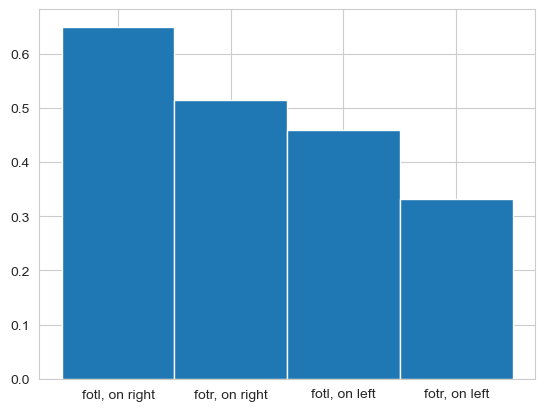

In [13]:
#preds_sorted_named = [(map_names_back(x[0]),x[1][0])  for x in preds_sorted] #stores the probability that fotl scores
preds_sorted_named = make_arr_of_touch(epee_model)
plt.bar([x[0] for x in preds_sorted_named],[x[1] for x in preds_sorted_named],1)#[x[1] for x in preds_sorted_named])

c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<BarContainer object of 4 artists>

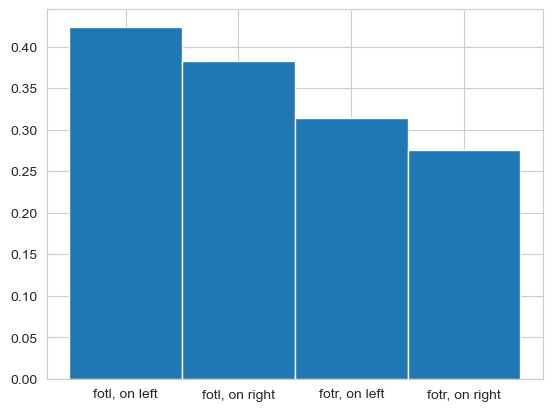

In [14]:
preds_sorted_named = make_arr_of_touch(foil_model)
plt.bar([x[0] for x in preds_sorted_named],[x[1] for x in preds_sorted_named],1)

c:\Users\Kow\miniconda3\envs\erdos_sp_2024\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<BarContainer object of 4 artists>

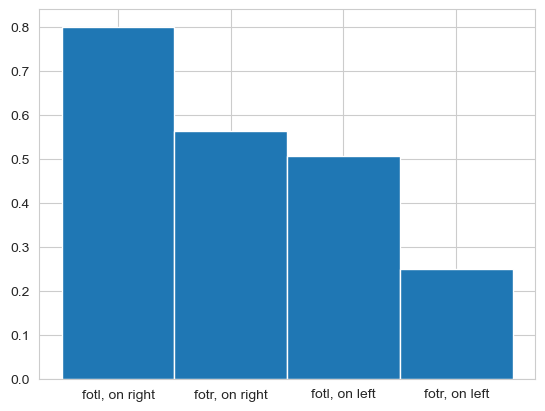

In [15]:
preds_sorted_named = make_arr_of_touch(saber_model)
plt.bar([x[0] for x in preds_sorted_named],[x[1] for x in preds_sorted_named],1)